# BD04 Data Science - Casus Anomaly Detection

#### Projectleden:
Chantal Favié, Kane Doornbos, Max Smeets, Sabrine Bouchmal

### Opdrachtgevers/begeleiders
Jan Baljan, Maarten Vaessen, Roel Bindels 


## Aanleiding

TODO: Omschrijven

Kinderen met de zeldzame spierziekte JDM (Juveniele Dermatomyositis) worden met behulp van de
Childhood Myositis Assessment Scale (CMAS) gemonitoord. Met de CMAS is het mogelijk om
spierzwakte te kunnen meten. De CMAS-meting is kort gezegd de maatstaaf die gebruikt wordt om
kinderen te meten met de zeldzame spierzwakte JDM. De kinderen moeten hiervoor frequent naar
het ziekenhuis voor behandelingen en de CMAS-meting. Door gebruik te maken van iDBPS kan de
meting op een laagdrempelige manier thuis worden uitgevoerd. Er wordt voor deze meting door
iDBPS alleen gebruik gemaakt van een camera, zoals deze aanwezig is in de huidige laptops en
mobiele telefoons. Hiervoor wordt gebruik gemaakt van kunstmatige intelligentie die de
lichaamshouding analyseert. De oefeningen kunnen dan door het kind thuis worden uitgevoerd.
De pipeline voor iDBPS bestaat uit 2 delen. In het eerste deel wordt een AI model ingezet om op
basis van een camera beeld de persoon en de postitie van de lichaamsdelen te herkennen. In het 2e
deel worden deze informatie gebruikt om een bepaalde lichaamshouding te herkennen en
automatisch te scoren. Voor dit 2e deel is het belangrijk dat de data uit de lichaamsherkenning
betrouwbaar en van hoge kwaliteit is. Bij de huidige AI modellen is dit niet altijd het geval en hier
zoeken wij een oplossing voor.

## Doelstelling

TODO: Omschrijven

Het doel van de casus is het onderzoeken, ontwerpen en realiseren van een methode die als input
de output van een lichaamsherkenning AI-model neemt en 1) bepaald of deze betrouwbaar en van
hoge kwaliteit is, 2) zo mogelijk, deze "repareert" en alsnog bruikbaar maakt voor de rest van de
pipeline.


## Dataset omschrijving
Voor de rauwe data worden video opnamens gemaakt van bepaalde fysieke bewegingen.
Videodata wordt vervolgens geanalyseerd door een pose detectie model waar diverse herkenningspunten op het lichaam geregistreerd worden. Dit resulteert in een json bestand waar voor elk herkenningspunt op vaste intervals de x en y coordinaat binnen het canvas opgeslagen worden.

Een voorbeeld momentopname van een herkenningspunt ziet er als volgt uit:
```
{
        "_index": "logstash-2021.03.10-000001",
        "_type": "_doc",
        "_id": "Kw1eHHgBhLy4-w68XmUL",
        "_score": 1.0,
        "_source": {
                "frameDate": "2021-03-10T13:40:49.336Z",
                "y": 256.41362694914704,
                "x": 371.01454493600573,
                "keypointName": "leftElbow",
                "keypointScore": 0.8112194538116455,
                "@version": "1",
                "frameScore": 0.644375700284453,
                "testStart": "2021-03-10T13:40:45.594Z",
                "elapsedSeconds": 3875,
                "@timestamp": "2021-03-10T13:40:49.773Z"
        }
}
```

## Data retrieval

Data wordt in de volgende mapstructuur opgeslagen:
- data
  - testpersoon
    - testgegevens

Om al deze gegevens in een enkele dataset te verwerken is een alogritme nodig om deze folders te kunnen parsen.

#### Algoritme requirements
- Kan het pad naar de JSON file vanuit de root folder genereren.
- Kan JSON bestanden inlezen.
- Kan meerdere JSON bestanden combineren naar een enkele dataframe.
- Kan onderscheid maken tussen de verschillende soorten oefeningen.
- Is eenvoudig uitbreidbaar met nieuwe oefeningen en/of testpersonen.
- Heeft een tijdscomplexiteit lager dan O(N²)

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [ ]:
# Increase max columns
pd.set_option('display.max_columns',100)

In [ ]:
# Empty files dictionary
files = {"arm": [],"raap": [],"zit": []}
# Define base path
path = './data/'
dir_list = os.listdir(path)
# Check for person folders in base path
# Index 0 = metingen.csv therefore index starts at 1
for folder in range(1, len(dir_list)):
    # Iterate subfolder for files
    sub_dir_list = os.listdir('./data/' + dir_list[folder])
    # Check for json file and exercise type
    # Add to corresponding dictionary key
    for person in range(len(sub_dir_list)):
        # Define path for each file
        item = path + str(dir_list[folder]) + '/' + str(sub_dir_list[person]) 
        if '.json' in item:
            if 'Zit' in item:
                files['zit'].append(item)
            elif 'Raap' in item:
                files['raap'].append(item)
            elif 'Arm' in item:
                files['arm'].append(item)
            else:
                print('Unknown exercise')

In [92]:
df = pd.DataFrame([])

# Loop through exercise dictionary keys
for i in files:
    # Concatinate json files to dataframe
    for file in range(len(files[i])):
        with open(files[i][file]) as data_file:
            data = json.load(data_file)
            df = pd.concat([df, pd.json_normalize(data['hits']['hits'])])

## Data cleaning

In [83]:
# Drop non computable columns
df = df.drop(axis=1, labels=['_index', '_type', 
                             '_score', '_source.y', 
                             '_source.x', '_source.@version', 
                             '_source.elapsedSeconds', 
                             '_source.testStart', 
                             '_source.@timestamp'])

df

,_id,_source.frameDate,_source.keypointName,_source.keypointScore,_source.frameScore
0,Kw1eHHgBhLy4-w68XmUL,2021-03-10T13:40:49.336Z,leftElbow,0.811219,0.644376
1,LA1eHHgBhLy4-w68XmUL,2021-03-10T13:40:49.336Z,leftEar,0.118284,0.644376
2,LQ1eHHgBhLy4-w68XmUL,2021-03-10T13:40:49.224Z,rightAnkle,0.799555,0.588665
3,Lg1eHHgBhLy4-w68XmUL,2021-03-10T13:40:49.224Z,rightHip,0.989071,0.588665
4,Lw1eHHgBhLy4-w68XmUL,2021-03-10T13:40:49.224Z,rightElbow,0.446836,0.588665
...,...,...,...,...,...
777,IVnPY3gBhLy4-w68uuEu,2021-03-24T10:37:37.889Z,rightAnkle,0.882222,0.940142
778,fFnPY3gBhLy4-w68uuAs,2021-03-24T10:37:38.902Z,leftShoulder,0.997221,0.947431
779,IlnPY3gBhLy4-w68uuEu,2021-03-24T10:37:37.889Z,rightHip,0.977018,0.940142
780,fVnPY3gBhLy4-w68uuAs,2021-03-24T10:37:38.902Z,leftEye,0.961725,0.947431


In [84]:
# Dataframe column types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68000 entries, 0 to 781
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id                    68000 non-null  object 
 1   _source.frameDate      68000 non-null  object 
 2   _source.keypointName   68000 non-null  object 
 3   _source.keypointScore  68000 non-null  float64
 4   _source.frameScore     68000 non-null  float64
dtypes: float64(2), object(3)
memory usage: 3.1+ MB


In [85]:
# Checking for missing values
df.isna().sum()


_id                      0
_source.frameDate        0
_source.keypointName     0
_source.keypointScore    0
_source.frameScore       0
dtype: int64

In [86]:
# Keypoint score statistics
df['_source.keypointScore'].describe()

count    68000.000000
mean         0.904942
std          0.169386
min          0.002355
25%          0.898548
50%          0.984762
75%          0.995711
max          0.999657
Name: _source.keypointScore, dtype: float64

In [87]:
# Frame score statistics
df['_source.frameScore'].describe()

count    68000.000000
mean         0.904942
std          0.100724
min          0.116615
25%          0.912016
50%          0.940786
75%          0.952201
max          0.971986
Name: _source.frameScore, dtype: float64

In [88]:
# Get mean keypoint and frame scores for every keypoint
df_means = df.groupby('_source.keypointName').mean(numeric_only=True)
df_means = df_means.reset_index()

df_means

,_source.keypointName,_source.keypointScore,_source.frameScore
0,leftAnkle,0.888133,0.904942
1,leftEar,0.655326,0.904942
2,leftElbow,0.942356,0.904942
3,leftEye,0.896823,0.904942
4,leftHip,0.983751,0.904942
5,leftKnee,0.977295,0.904942
6,leftShoulder,0.971528,0.904942
7,leftWrist,0.912444,0.904942
8,nose,0.919015,0.904942
9,rightAnkle,0.871017,0.904942


## Data visualisation

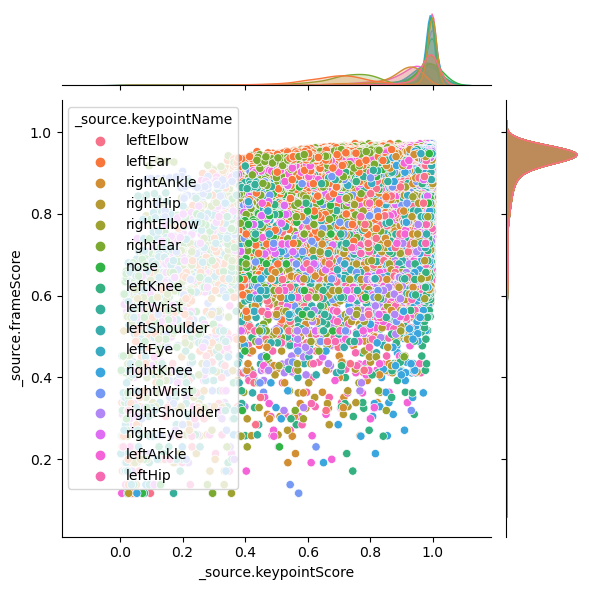

In [89]:
# Categorical jointplot
sns.jointplot(data=df, 
              x="_source.keypointScore", 
              y="_source.frameScore", 
              hue='_source.keypointName'
            )

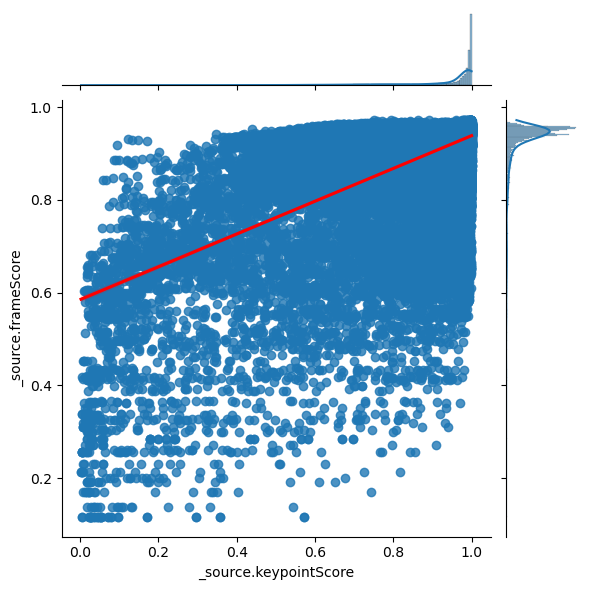

In [90]:
# Joint plot with regression line
sns.jointplot(data=df, 
              x="_source.keypointScore", 
              y="_source.frameScore", 
              kind="reg", 
              joint_kws={"line_kws":{'color':'red'}}
            )

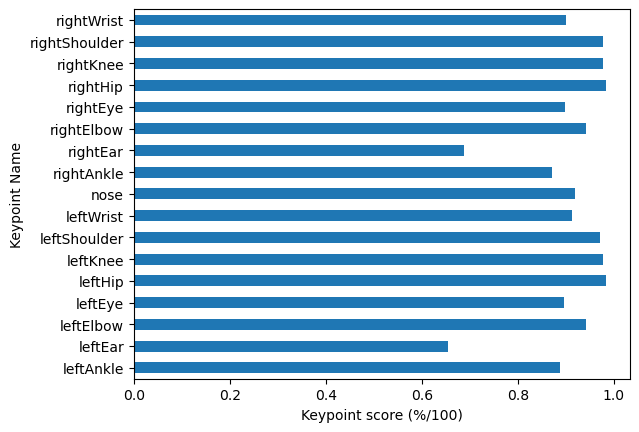

In [91]:
# Bar chart for mean keypoint values
ax = df_means.plot.barh(x='_source.keypointName', 
                        y='_source.keypointScore',
                        legend = False, 
                        ylabel="Keypoint Name", 
                        xlabel="Keypoint score (%/100)")


## Model

TODO: Analyse schrijven voor meest geschikte model (hypothese naar validatie)

- PoseNet ( ? )
- MoveNet Lightning (Performance > Accuracy)
- MoveNet Thunder (Accuracy > Performance)

## Aantekeningen meeting week 2
- POSENET tensorflow library voor oefeningen gebruikt
- Ook andere modellen mogelijk (mediapipe)
- Model zsm draaiende hebben, dan zelf video opnamens maken
- Kibana (dashboard voor data te bekijken)